# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 4. Матричный профиль. Поиск примитивов на его основе.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Смена рабочей директории.

In [2]:
import os
os.chdir('/content/drive/MyDrive/TimeSeriesCourse/practice/04 Matrix profile')

Использование команд, которые автоматически перезагружают все импортированные модули при их изменении.

In [3]:
%load_ext autoreload
%autoreload 2

Для выполнения данной практической работы используйте библиотеку *stumpy*, предназначенную для анализа временных рядов на основе матричного профиля.

Установите библиотеку *stumpy*.

In [4]:
%%capture
!pip install stumpy

## **Часть 1.** Матричный профиль. Поиск мотивов и диссонансов.

Импорт библиотек и модулей.

In [5]:
import pandas as pd
import numpy as np

from modules.plots import *
from modules.mp import *
from modules.motifs import *
from modules.discords import *

### **Задача 1.**
Загрузите временной ряд, который содержит данные о почасовом потреблении электроэнергии некоторого итальянского города, снимаемые в течение 3 лет, начиная с 1 января 1995 года.

In [6]:
ts_url = './datasets/part1/italianpowerdemand.csv'

ts = pd.read_csv(ts_url, header=None).squeeze().to_numpy()

Визуализируйте временной ряд, используя функцию `plot_ts()` из модуля *plot.py*.

In [7]:
plot_ts(ts, "Input time series")

Изучите [документацию](https://stumpy.readthedocs.io/en/latest/index.html) библиотеки *stumpy*. Напишите функцию `calculate_mp()` в модуле *mp.py*, которая вычисляет матричный профиль временного ряда на основе выбранной вами функции из библиотеки *stumpy*.

In [8]:
m = 165
exclusion_zone = int(np.ceil(m / 2))
mp = {}

mp = compute_mp(ts, m, exclusion_zone)

Визуализируйте найденный матричный профиль временного ряда.

In [9]:
plot_ts(mp['mp'], "Matrix Profile")

### **Задача 2.**
Найдите top-$k$ мотивов во временном ряде на основе построенного матричного профиля.

In [10]:
top_k = 6
motifs = {}

motifs_ = stumpy.motifs(ts, mp['mp'], cutoff = np.nanmean(mp['mp']), max_motifs = top_k)
motifs['distances'] = motifs_[0]
motifs['indices'] = motifs_[1]

Выполните визуализацию найденных top-$k$ мотивов.

In [11]:
plot_motifs(mp, motifs)

*Матричный профиль содержит евклидовы расстояния между подпоследовательностями ряда, следовательно используя его можно отыскать мотивы - часто повторяющиеся подпоследовательности (их расстояние будет близко к 0)*

### **Задача 3.**
Найдите top-$k$ диссонансов во временном ряде на основе матричного профиля.

Для решения данной задачи загрузите временной ряд, содежащий данные о среднем числе пассажиров NY такси за осень 2014 года.

In [12]:
ts_url = './datasets/part1/nyc_taxi.csv'

ts = pd.read_csv(ts_url, index_col=0, header=0).squeeze().to_numpy()

In [13]:
plot_ts(ts, "Input time series")

Найдите матричный профиль и на его основе top-$k$ диссонансы.

In [14]:
m = 96
exclusion_zone = int(np.ceil(m / 2))
mp = {}

mp = compute_mp(ts.astype(np.float64), m, exclusion_zone)

In [21]:
top_k = 15
discords = {}

def check(list_idx, idx, exc_zone):
  for idx_ in list_idx:
    if abs(idx_ - idx) < exc_zone:
      return False
  return True

top_k_idxs = []
sorted_mp = np.argsort(mp['mp'])
for i in range(len(sorted_mp) - 1, -1, -1):
    idx = sorted_mp[i]
    if check(top_k_idxs, idx, exclusion_zone):
        top_k_idxs.append(idx)
    if len(top_k_idxs) == top_k:
        break

discords['indices'] = top_k_idxs

Выполните визуализацию найденных top-$k$ диссонансов.

In [22]:
plot_discords(mp, discords)

*В задаче поиска диссонансов можно также воспользоваться матричным профилем, с идеей, что подпоследовательности, с наибольшим расстоянием относительно других будут диссонансами*

## **Часть 2.** Сегментация повторяющихся активностей.

### **Задача 4.**

Загрузите временной ряд PAMAP, представляющий собой показания закрепленного на человеке виброакселерометра. Данный ряд включает показания при трех видах физической активности: ходьба, подъем по лестнице, спуск по лестнице.

In [23]:
ts_url = './datasets/part2/pamap.csv'

ts = pd.read_csv(ts_url, header=None).squeeze().to_numpy()

Визуализируйте временной ряд PAMAP.

In [24]:
plot_ts(ts, "Input time series")

Найдите и визуализируйте матричный профиль временного ряда.

In [25]:
m = 100
exclusion_zone = m
mp = {}

mp = compute_mp(ts, m, exclusion_zone)

In [26]:
plot_ts(mp['mp'], "Matrix Profile")

Вычислите порог по формуле, которая представлена в презентации [04 Matrix profile.pdf](https://github.com/mzym/TimeSeriesCourse/blob/main/slides/04%20Matrix%20profile.pdf).

In [28]:
a = 0.5
threshold = a * (np.min(mp['mp']) + np.max(mp['mp'][np.where(mp['mp'] != float('inf'))]))
threshold

6.246194213007073

Выполните визуализацию результатов сегментации повторяющихся активностей.

In [29]:
plot_segmentation(mp, threshold)

Загрузите истинную разметку временного ряда PAMAP, где 0 – ходьба, 1 – подъем по лестнице, 2 – спуск с лестницы. Вычислите точность по метрике accuracy, сравнив полученные результаты по основе матричного профиля с истинной разметкой.

In [30]:
labels_url = './datasets/part2/pamap_labels.csv'

labels = pd.read_csv(labels_url, header=None).squeeze().to_numpy()

In [57]:
labels_pred = [(2 if val >= threshold else 1) for val in mp['mp']]

In [72]:
labels = labels[:30901]
labels = np.where(labels==0, 2, labels)

In [73]:
from sklearn.metrics import accuracy_score

accuracy_score(labels, labels_pred)

0.7142487298145691

## **Чaсть 3.** Casy Study: Раскрытие краж электричества подменой счетчиков (meter-swapping detection).


### **Задача 5.**

Рассмотрим практическое применение использования матричного профиля для решения задачи, связанной с раскрытием краж электричества путем подмены счетчиков.

Загрузите временные ряды из директории *./datasets/part3/*, которые были выбраны случайным образом из набора данных (House 1, 2, 3, 4 и 11), содержащего данные потребления электроэнергии 20 жилых домов в Великобритании с 1 января по 23 декабря 2013 года.

In [ ]:
import os
import datetime

from modules.meter_swapping_detection import *

In [ ]:
path = './datasets/part3/'

house_idx = [1, 2, 3, 4, 11]

filenames = [f"House{i}.csv" for i in house_idx]

consumptions = {}
for house in filenames:
    consumptions[house[:-4]] = pd.read_csv(os.path.join(path, house), header=None, index_col=0)
    consumptions[house[:-4]].index = pd.to_datetime(consumptions[house[:-4]].index, dayfirst=True)

Далее смоделируем событие замены счетчика. Для этого каждый временной ряд разделим на две части: "Head" (до 10 октября) и "Tail" (после 10 октября). После чего выберем случайным образом 2 временных ряда (например, House1 и House11) и поменяем местами их "Tail" части.

In [ ]:
cutoff = pd.to_datetime('2014-10-01')
heads, tails = heads_tails(consumptions, cutoff, house_idx)

#swap Heads and Tails of 1 and 11
swap1, swap2 = 1, 11
consumptions[f'House{swap1}'] = heads[f'H_{swap1}'].append(tails[f'T_{swap2}'])
consumptions[f'House{swap2}'] = heads[f'H_{swap2}'].append(tails[f'T_{swap1}'])
heads, tails = heads_tails(consumptions, cutoff, house_idx)

Визуализируйте исходные временные ряды и параллельную оси OY прямую, которая делит временные ряды на "Head" и "Tail" части.

In [ ]:
plot_consumptions_ts(consumptions, cutoff, house_idx)

Чтобы найти переставленную пару временных рядов, выполним следующее. Сначала составим временные ряды $H_i$ из всевозможных комбинаций "Head" и "Tail" частей исходных временных рядов $T_K$, где $1 \leq i \leq |T|^2$, $1 \leq K \leq |T|$. В нашем случае, $|T| = 5$.  Далее среди них найдем такую пару временных рядов $(H_i, H_j)$, которая имеет минимальную оценку $swap\_score$. Минимальная оценка $swap\_score$ для пары рядов $(H_i, H_j)$ вычисляется следующим образом:

\begin{equation}
swap\_score(i,j) = \frac{\min{(Head_{H_i} \bowtie Tail_{H_j})}}{\min{(Head_{H_i} \bowtie Tail_{H_i})}+eps},
\end{equation}

где $\bowtie$ – операция нахождения матричного профиля между двумя временными рядами. Матричный профиль между двумя временными рядами содержит расстояния между всеми подпоследовательностями первого временного ряда и их ближайшими соседями, которые являются подпоследовательностями второго временного ряда.

Добавьте в функцию `compute_mp()` в модуле *mp.py* поддежку вычисления матричного профиля между двумя различными временными рядами и найдите пару временных рядов $(H_i, H_j)$, которая имеет минимальную оценку $swap\_score$ среди всех пар.

In [ ]:
m = 24 * 4

min_score = meter_swapping_detection(heads, tails, house_idx, m)

In [ ]:
min_i, min_j, mp_j = min_score['i'], min_score['j'], min_score['mp_j']
print(f'Time series with minimum score is (H_{min_i}, T_{min_j}).')

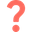
Проанализируйте и изложите содержательный смысл полученных результатов.

*# WRITE YOUR ANSWER*